## Overview The Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import seaborn as sns

## Dataset Analysis
Exmaple of a picture of each classe.
(paper, glass, plastic)

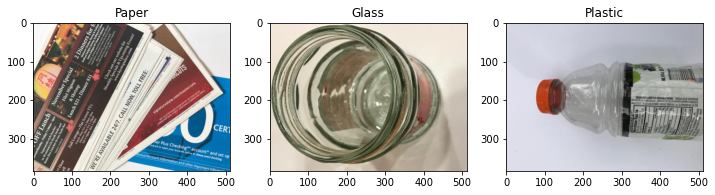

In [2]:
paper = "./archive/garbage_classification/images/paper/paper100.jpg"
glass = "./archive/garbage_classification/images/glass/glass21.jpg"
plastic = "./archive/garbage_classification/images/plastic/plastic21.jpg"

img1 = Image.open(paper)
img2 = Image.open(glass)
img3 = Image.open(plastic)

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis("on")
plt.title("Paper")

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis("on")
plt.title("Glass")

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis("on")
plt.title("Plastic")
plt.show()

Picture's path for each classe.

In [3]:
glass= "./archive/garbage_classification/images/glass/"
paper= "./archive/garbage_classification/images/paper/"
plastic=  "./archive/garbage_classification/images/plastic/"

dict = {}
dict[0] = 'glass'
dict[1] = 'plastic'
dict[2] = 'paper'

## Data Preparation

The dataset is not balanced. Using the data as it is will probably show wrong results and we may suffer of Overfitting. This means that we need to do some pre processing in order to be able to make conclusions.

Glass: 31.761 % 
Paper: 37.676 % 
Plastic: 30.563 % 


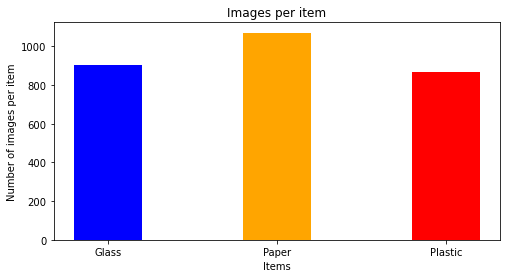

In [5]:
glass_items=902
paper_items=1070
plastic_items=868

print('Glass:', round(glass_items/(glass_items+paper_items+plastic_items) * 100,3), '% ')
print('Paper:', round(paper_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')
print('Plastic:', round(plastic_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')

data = {'Glass': glass_items, 'Paper': paper_items, 'Plastic': plastic_items}
items = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("Number of images per item")
plt.title("Images per item")
plt.show()

In order of the results above we decided to balance the dataset and only use the same number of images of each classe, thus making the dataset balanced

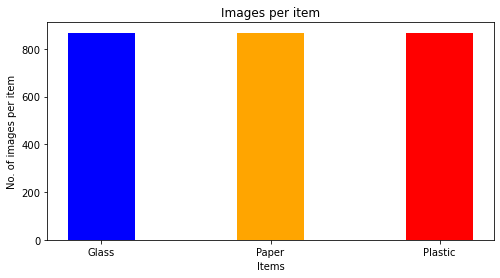

In [6]:
num_images=868 # 868 beacause it is the lowest number from the three classes (plastic)

data = {'Glass': num_images, 'Paper': num_images, 'Plastic': num_images}
items = list(data.keys()) # get different garbage types
values = list(data.values()) # get number of images by each type of garbage 

# create a bar plot to show the balanced dataset
fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("No. of images per item")
plt.title("Images per item")
plt.show()

In order to make more easy and lower the number of features we decided to resize each image to 128x128 pixels, beacuse initially the lower size was 512x384 which leads to a higher number of features, and also was very time consuming.

In [7]:
img_size = 128
train_images = []

for p in range(1,num_images+1):
    image = Image.open(glass+"glass"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(plastic+"plastic"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(paper+"paper"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    train_images.append(image)

## Data Normalization

In [8]:
X = np.empty((num_images*3, img_size* img_size*3))
index = 0
for pl in train_images:
    # Normalize pixel values
    pixels = asarray(pl)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    X[index] = pixels.reshape(img_size * img_size * 3)
    index += 1
g = np.zeros(num_images)
m = np.ones(num_images)
p = np.empty(num_images)
p.fill(2)
y = np.concatenate((g, m, p), axis=0).reshape(X.shape[0], 1)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (2604, 49152)
y shape:  (2604, 1)


Splitting the dataset into training subset and testing subset, using 20% of the dataset to test

In [40]:

y = y.ravel()

# extract train sub-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling and normalization of data
st_x = StandardScaler()    
X_train = st_x.fit_transform(X_train)    
X_test = st_x.transform(X_test) 

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2083, 49152)
y train: (2083,)
X test: (521, 49152)
y test: (521,)


## Models

In [31]:
def model_train(model, name, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    test_data_accuracy = accuracy_score(y_pred, y_test)

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print()
    print("- MODEL ANALYSIS")
    print("Accuracy (train) for %s: %0.5f%% " % (name, test_data_accuracy * 100))
    print('Precision Score for %s: %0.5f%%' %(name, precision*100))
    print('Recall Score for %s: %0.5f%%' %(name, recall*100))
    print('F1 Score for %s: %0.5f%%' %(name, f1*100))
    
    print()
    
    print("-------- Confusion Matrix -------")
    index = ('glass', 'plastic', 'paper')
    cm = confusion_matrix(y_test, y_pred)

    dataframe = pd.DataFrame(cm, index=index, columns=index)

    print(dataframe)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print()
    print("------- Classification Report -------")
    print( classification_report(y_test, model.predict(X_test)) )

def kfold(model, k, X_train, y_train):
    print("- K-FOLD CROSS-VALIDATION")
    
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

def hyperparameters(model, params, X, y):
    print("- FIND HYPERPARAMETERS FOR A MODEL")

    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params:", model.best_params_)

    return model.best_params_

## Logistic Regression


- MODEL ANALYSIS
Accuracy (train) for Logistic Regression: 85.22073% 
Precision Score for Logistic Regression: 85.76217%
Recall Score for Logistic Regression: 85.44027%
F1 Score for Logistic Regression: 85.22226%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      150       20     11
plastic      9      154      1
paper       15       21    140


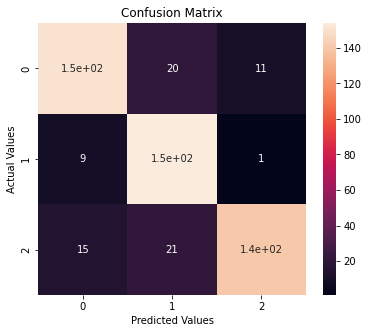


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       181
         1.0       0.79      0.94      0.86       164
         2.0       0.92      0.80      0.85       176

    accuracy                           0.85       521
   macro avg       0.86      0.85      0.85       521
weighted avg       0.86      0.85      0.85       521

- K-FOLD CROSS-VALIDATION


KeyboardInterrupt: 

In [42]:
# Using multinomial logistic regression
model = LogisticRegression(max_iter=2000)
model_train(model,'Logistic Regression', X_train, y_train, X_test, y_test)

# Hypertuned Params
model_params = [{'multi_class': ['multinomial', 'ovr'], 'max_iter': [800, 2000, 10000]}]
best_model_params = hyperparameters(model, model_params , X_train, y_train)

model.set_params(**best_model_params)
model_train(model, 'Logistic Regression', X_train, y_train, X_test, y_test)

# K-Fold Cross-Validation
kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel, 'Logistic Regression', X_train, y_train, X_test, y_test)

## Neural Network


- MODEL ANALYSIS
Accuracy (train) for NN: 85.22073% 
Precision Score for NN: 85.36922%
Recall Score for NN: 85.19394%
F1 Score for NN: 85.19606%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      160       12      9
plastic     16      140      8
paper       16       16    144


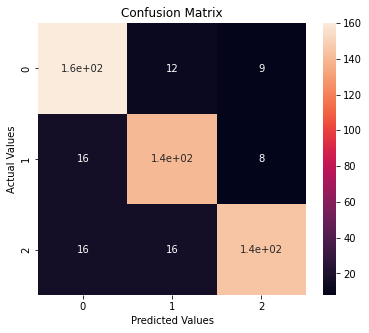


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       181
         1.0       0.83      0.85      0.84       164
         2.0       0.89      0.82      0.85       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.85      0.85       521

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'activation': 'logistic', 'hidden_layer_sizes': (6,), 'max_iter': 20000, 'solver': 'adam'}

- MODEL ANALYSIS
Accuracy (train) for NN: 79.46257% 
Precision Score for NN: 79.89545%
Recall Score for NN: 79.75590%
F1 Score for NN: 79.39411%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      124       42     15
plastic     10      144     10
paper       18       12    146


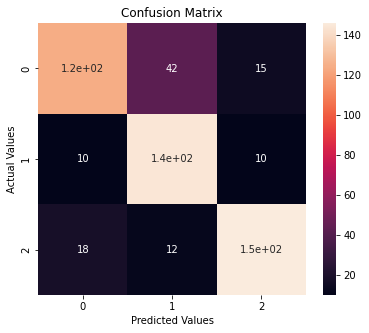


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.74       181
         1.0       0.73      0.88      0.80       164
         2.0       0.85      0.83      0.84       176

    accuracy                           0.79       521
   macro avg       0.80      0.80      0.79       521
weighted avg       0.80      0.79      0.79       521

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Accuracy (train) for NN: 77.15931% 
Precision Score for NN: 77.18779%
Recall Score for NN: 77.33257%
F1 Score for NN: 77.04367%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      121       40     20
plastic     19      132     13
paper       16       11    149


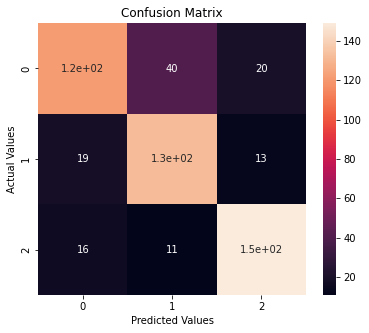


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72       181
         1.0       0.72      0.80      0.76       164
         2.0       0.82      0.85      0.83       176

    accuracy                           0.77       521
   macro avg       0.77      0.77      0.77       521
weighted avg       0.77      0.77      0.77       521



In [34]:
model = MLPClassifier(max_iter=20000)

model_train(model,'NN', X_train, y_train, X_test, y_test)

mlp_parameters = {
    'hidden_layer_sizes': [(2,),(4,),(6,),(8,)],
    'activation': ['logistic', 'tanh'],
    'solver': [ 'adam'],
    'max_iter': [10000, 20000],
}

hyper_mlp_parameters = hyperparameters(model, mlp_parameters , X_train, y_train)
model.set_params(**hyper_mlp_parameters)
model_train(model,'NN', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'NN', X_train, y_train, X_test, y_test)


## Random Forest


---- Model Analysis ----
Accuracy (train) for RFC: 94.4% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      171        7      3
plastic      7      156      1
paper        7        4    165


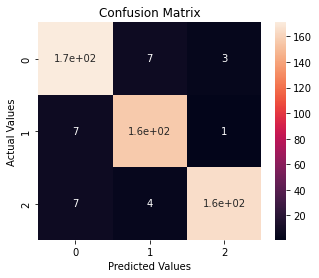


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       181
         1.0       0.93      0.95      0.94       164
         2.0       0.98      0.94      0.96       176

    accuracy                           0.94       521
   macro avg       0.94      0.94      0.94       521
weighted avg       0.94      0.94      0.94       521



In [11]:
model = RandomForestClassifier()

model_train(model, 'RFC', X_train, y_train, X_test, y_test)

rfc_parameters = { 
    'max_features': ['auto', 'sqrt'],
    'criterion' :['gini', 'entropy'],
}

hyper_rfc_parameters = hyperparameters(model, rfc_parameters , X_train, y_train)
model.set_params(**hyper_rfc_parameters)
model_train(model,'RFC', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'RFC', X_train, y_train, X_test, y_test)

## Decision Tree


- MODEL ANALYSIS
Accuracy (train) for DecisionTree: 88.29175% 
Precision Score for DecisionTree: 88.34006%
Recall Score for DecisionTree: 88.36466%
F1 Score for DecisionTree: 88.34578%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      157       10     14
plastic     11      149      4
paper       14        8    154


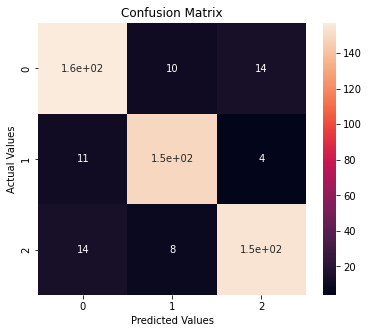


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       181
         1.0       0.89      0.91      0.90       164
         2.0       0.90      0.88      0.89       176

    accuracy                           0.88       521
   macro avg       0.88      0.88      0.88       521
weighted avg       0.88      0.88      0.88       521

- FIND HYPERPARAMETERS FOR A MODEL
 Best Params: {'criterion': 'entropy', 'max_depth': 10}

- MODEL ANALYSIS
Accuracy (train) for DecisionTree: 85.22073% 
Precision Score for DecisionTree: 85.79965%
Recall Score for DecisionTree: 85.32234%
F1 Score for DecisionTree: 85.30747%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      154       23      4
plastic     13      147      4
paper       22       11    143


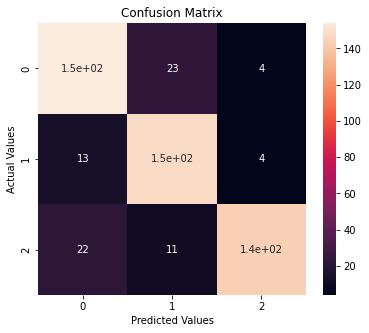


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       181
         1.0       0.81      0.90      0.85       164
         2.0       0.95      0.81      0.87       176

    accuracy                           0.85       521
   macro avg       0.86      0.85      0.85       521
weighted avg       0.86      0.85      0.85       521

- K-FOLD CROSS-VALIDATION

- MODEL ANALYSIS
Accuracy (train) for DecisionTree: 84.45298% 
Precision Score for DecisionTree: 84.89461%
Recall Score for DecisionTree: 84.58230%
F1 Score for DecisionTree: 84.55452%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      148       27      6
plastic     14      146      4
paper       21        9    146


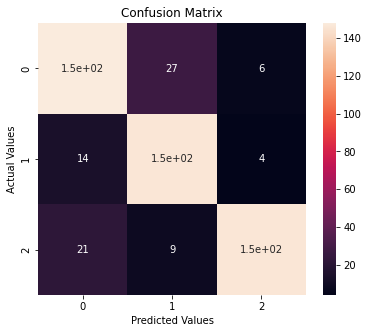


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81       181
         1.0       0.80      0.89      0.84       164
         2.0       0.94      0.83      0.88       176

    accuracy                           0.84       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.85      0.84      0.85       521



In [35]:
model = DecisionTreeClassifier()

model_train(model, 'DecisionTree', X_train, y_train, X_test, y_test)

dt_parameters = {'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12]}

hyper_dt_parameters = hyperparameters(model, dt_parameters , X_train, y_train)
model.set_params(**hyper_dt_parameters)
model_train(model,'DecisionTree', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel,'DecisionTree', X_train, y_train, X_test, y_test)


- MODEL ANALYSIS
Accuracy (train) for SVM: 85.60461% 
Precision Score for SVM: 85.59149%
Recall Score for SVM: 85.73096%
F1 Score for SVM: 85.59371%

-------- Confusion Matrix -------
         glass  plastic  paper
glass      143       26     12
plastic     13      145      6
paper       13        5    158


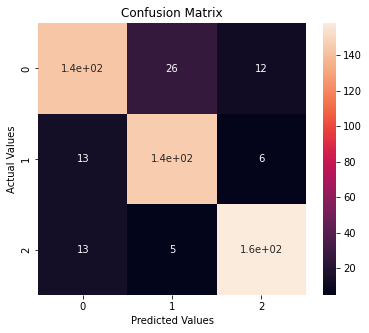


------- Classification Report -------
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       181
         1.0       0.82      0.88      0.85       164
         2.0       0.90      0.90      0.90       176

    accuracy                           0.86       521
   macro avg       0.86      0.86      0.86       521
weighted avg       0.86      0.86      0.86       521



In [44]:
model = SVC()

model_train(model, 'SVM', X_train, y_train, X_test, y_test)

svm_parameters = [{'C': [0.01, 0.1, 1, 10, 50, 100, 1000], 
              'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1],
              'kernel': ['rbf']}]
best_svm_params = hyperparameters(model, svm_parameters , X_train, y_train)

model.set_params(**best_svm_params)
model_train(model,'SVM', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel, 'SVM', X_train, y_train, X_test, y_test)

## Model Comparison

We are using a box plot to display and compare the results from the models.

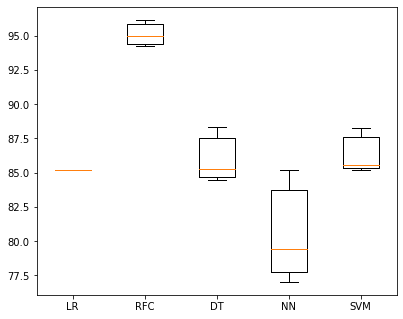

In [45]:
LR = [85.22, 85.22, 85.22]
RFC = [95.01, 94.24, 96.16, 94.99, 94.25, 96.16]
DT = [88.29, 85.22, 84.45, 88.35, 85.31, 84.55]
NN = [85.22, 79.46, 77.16, 85.20, 79.39, 77.04]
SVM = [85.60, 88.30, 85.22, 85.59, 88.27, 85.22]

data = [LR, RFC, DT, NN, SVM]

fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, labels=["LR", "RFC", "DT", "NN", "SVM"])
 
# show plot
plt.show()
